# Neural inference for neurotransmission recovery models

In [321]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import torch
import xarray as xr

from enum import IntEnum
from typing import Union
from torchaudio.functional import convolve

# Local import
from include import neural_net
%matplotlib inline

## Load animal data

In [357]:
# Load the current data, which has 3000 time steps and is animal-specific
times = torch.from_numpy(np.load("../../Projects/Parameter_estimation_nn/calcium_rre/data/times.npy")).float()
currents = dict((f"animal{i}", torch.from_numpy(np.load(f"../../Projects/Parameter_estimation_nn/calcium_rre/data/Current_data_animal{i}.npy")).float()) for i in range(1, 6))

[Text(0.5, 0, '$t \\ [s]$')]

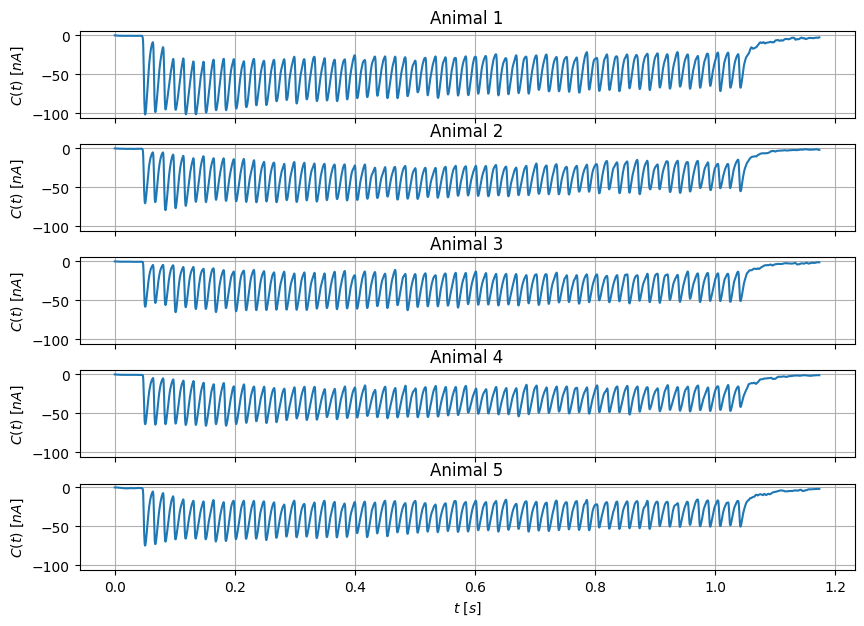

In [367]:
# Plot the current
fig, axs = plt.subplots(nrows=5, figsize=(10, 7), sharex=True, sharey=True, gridspec_kw=dict(hspace=0.3))
for i in range(1, 6):
    axs[i-1].plot(times, currents[f"animal{i}"] * 10**9)
    axs[i-1].grid()
    axs[i-1].set(title=f"Animal {i}", ylabel='$C(t) \ [nA]$')
axs[-1].set(xlabel='$t \ [s]$')

## Model parameters

In [334]:
# Animal-calibrated parameters using method II
ANIMAL_PARAMS = {
    "animal1": dict(N=334,  g_V=2.5,    g_P=94,     k_R=15.2,   n_v=15,     L=1.7,  m1=40.6,   m2=7.1e-5),
    "animal2": dict(N=250,  g_V=0.9,    g_P=93.6,   k_R=5.8,    n_v=31,     L=1.7,  m1=9.9,    m2=1.1e-8),
    "animal3": dict(N=172,  g_V=2.7,    g_P=160.6,  k_R=28.9,   n_v=17,     L=1.5,  m1=8.6,    m2=2.1e-4),
    "animal4": dict(N=230,  g_V=2.0,    g_P=97.2,   k_R=8.9,    n_v=18,     L=1.6,  m1=12.2,   m2=3.1e-6),
    "animal5": dict(N=248,  g_V=1.9,    g_P=76.8,   k_R=13.9,   n_v=18,     L=1.6,  m1=22.0,   m2=1.7e-3),
}

# Array of spike heights used for k_F
A = torch.cat([
    torch.tensor([1398.0, 1420.0, 1438.0, 1454.0, 1467.0, 1478.0, 1487.0, 1495.0,
                  1502.0, 1507.0, 1512.0, 1515.0, 1519.0, 1521.0, 1524.0, 1525.0,
                  1527.0, 1528.0, 1530.0, 1531.0, 1532.0, 1532.0, 1533.0, 1533.0,
                  1534.0, 1534.0, 1535.0, 1535.0, 1535.0, 1535.0]),
    torch.tensor([1536]).repeat(11),
    torch.tensor([1537]).repeat(19)]
).float()

# General parameters for model functions. All parameters are given in s, Hz, and Ampere
GENERAL_PARAMS = {
    "impulse_function": dict(A = 7.21e-6, B = 2.7e-9, t0 = 3e-3, tau_r = 10.6928, tau_df = 1.5e-3, tau_ds = 2.8e-3),
    "k_F": dict(m0 = 1, sigma = 1.25e-4, f_s = 60, A = A),
    "k_U": dict(k_min = 2.0e-8, k_max = 60, m3 = 3.3e4, m4 = 1.4e-3)
}

## Model ODE

In [323]:
# Define an enum for the parameters and compartments so we are sure to always index in a consistent way
class Parameters(IntEnum):
    R = 0
    U = 1
    F = 2

class Compartments(IntEnum):
    V = 0
    W_v = 1
    W_p = 2
    R = 3
    p = 4

In [324]:
# ODE to generate the data X and solve the ode
def solve_ODE(*, parameters: Union[dict, torch.Tensor],
                 num_steps: int,
                 init_state: torch.Tensor,
                 dt,
                 g_V,
                 g_P,
                 **__
) -> torch.Tensor:

    """ Forward Euler solver for the recovery model. Parameters can be passed either as a dictionary of tensors, each of shape (L, 1) or as a tensor of shape (L, p). If L=1 the parameters are interpreted as constant, else as a time series. If L > 1 it must be at least equal to num_steps (L>=num_steps). """

    # Single Euler step
    def _step(_state, _params):
        return _state + torch.stack([
            - _params[Parameters["R"].value] * _state[Compartments["V"].value] * _state[Compartments["p"].value] + g_V * _state[Compartments["W_v"].value] + _params[Parameters["U"].value] * _state[Compartments["R"].value],
            _params[Parameters["F"].value] * _state[Compartments["R"].value] - g_V * _state[Compartments["W_v"].value],
            _params[Parameters["F"].value] * _state[Compartments["R"].value] - g_P * _state[Compartments["W_p"].value],
            _params[Parameters["R"].value] * _state[Compartments["V"].value] * _state[Compartments["p"].value] - (_params[Parameters["F"].value] + _params[Parameters["U"].value]) * _state[Compartments["R"].value],
            - _params[Parameters["R"].value] * _state[Compartments["V"].value] * _state[Compartments["p"].value] + g_P * _state[Compartments["W_p"].value] + _params[Parameters["U"]] * _state[Compartments["R"].value]
        ]) * dt

    # Convert parameter dict to tensor, if required
    if isinstance(parameters, dict):
        parameters = torch.stack([parameters[key] for key in [e.name for e in Parameters]])

    #  Start from initial state
    data = [init_state]

    for t in range(num_steps):

        if parameters.shape[0] > 1:
            data.append(_step(data[-1], parameters[t]))
        else:
            data.append(_step(data[-1], parameters[0]))

    # Return the time series
    return torch.stack(data)

## Impulse function

In [325]:
# Impulse function (eq. A1), in seconds
def impulse_function(_t, *, A, B, t0, tau_r, tau_df, tau_ds, **__) -> torch.Tensor:
    _t = -(_t - t0)
    return -torch.relu(A * (1 - torch.exp(_t / tau_r)) * (B * torch.exp(_t / tau_df) + (1-B) * torch.exp(_t / tau_ds)))

In [326]:
# Tolu's impulse function, from the Github repo
def mEPSC_fun(*, dt, T):
    ###Parameters, don't change!
    size_of_mini = 0.6e-9 #A, Amplitude of mEJC, Estimated from variance-mean of data (see Fig 2F)
    A = -7.209251536449789e-06
    B = 2.709256850482493e-09
    t_0 = 0
    tau_rf = 10.692783377261414
    tau_df =0.001500129264510
    tau_ds = 0.002823055510748#*0.6
    length_of_mini =34*1e-3 # Length of ts, i've replaced with T

    """Return one mEPSC."""
    t = torch.arange(0,T,dt)
    mEPSC = (t >= t_0)*(A*(1-torch.exp(-(t-t_0)/tau_rf))*(B*torch.exp(-(t-t_0)/tau_df) + (1-B)*torch.exp(-(t-t_0)/tau_ds)))
    return t, -(mEPSC/min(mEPSC) *size_of_mini)

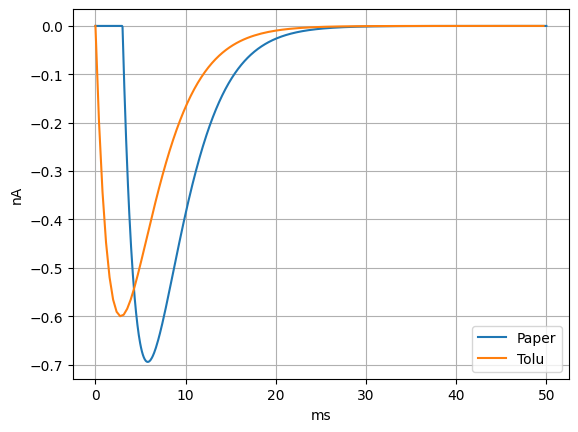

In [327]:
# Plot the impulse function
fig, ax = plt.subplots()
ax.plot(torch.linspace(0, 50, 1000), impulse_function(torch.linspace(0, 0.05, 1000), **GENERAL_PARAMS['impulse_function'])*10**9, label="Paper")
t_new, mepsc = mEPSC_fun(dt=0.0003912137379126375, T=0.05)
ax.plot(t_new*1e3, 10**9*mepsc, label="Tolu")
ax.grid()
ax.set(xscale='linear', xlabel='ms', ylabel='nA')
ax.legend()

## Function to calculate the current

In [328]:
# Current: derived by convolution
def calculate_current(*, R, k_F, g, N, dt, **__):

    # Convolve the derivative of F with impulse function
    return convolve(k_F * R, N*g, mode='full')[:len(R)] * dt

## $k_F$ and $k_U$ estimates

In [335]:
# K function (eqs. 11-13 in the paper)
def k_F(_t, *, L, m0, m1, m2, sigma, f_s, A, **__) -> torch.Tensor:

    # Baseline function
    f0 = m0 * 10 ** (L * (1 - torch.exp(-m1 * (_t - m2))))

    # Add Gaussian spikes
    f_gamma = torch.zeros_like(f0)
    for i in range(1, 61):
        f_gamma_temp = A[i-1] * torch.exp(-0.5 * ((_t - _t[torch.argmin(abs(_t-(i/f_s)))]) ** 2) / (sigma ** 2))
        f_gamma += f_gamma_temp

    # Return sum of both
    return f0 + f_gamma

# U function (eq. 14)
def k_U(_t, *, k_min, k_max, m3, m4, **__):
    return k_max * (1-torch.sigmoid(m3 * (_t - m4))) + k_min

[Text(0, 0.5, '$k_U \\ [Hz]$')]

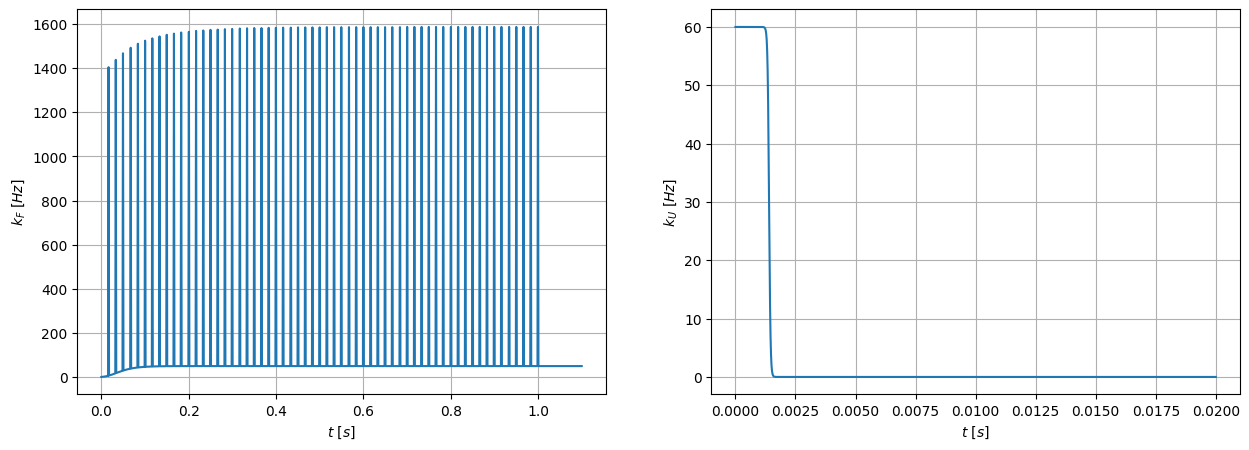

In [336]:
# Plot the functions for an example animal
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
axs[0].plot(torch.linspace(0, 1.1, 1000), k_F(torch.linspace(0, 1.1, 1000), **ANIMAL_PARAMS['animal1'], **GENERAL_PARAMS["k_F"]))
axs[1].plot(torch.linspace(0, 0.02, 1000), k_U(torch.linspace(0, 0.02, 1000), **GENERAL_PARAMS["k_U"]))
for ax in axs:
    ax.set(xlabel='$t \ [s]$')
    ax.grid()
axs[0].set(ylabel='$k_F \ [Hz]$')
axs[1].set(ylabel='$k_U \ [Hz]$')

## Generate ODE data

In [406]:
animal = "animal3"

# Recreate the calibrated data
dt = times.diff().mean()
print(f"dt: {dt}")
start, stop = 0, torch.argmin(abs(times-1))
num_steps = stop-start

# Initial steady state
init_state = torch.zeros(5)
init_state[Compartments["V"].value] = ANIMAL_PARAMS[animal]["n_v"]-1
init_state[Compartments["W_v"].value] = 0
init_state[Compartments["W_p"].value] = 0
init_state[Compartments["R"].value] = 1
init_state[Compartments["p"].value] = 0

# True parameters
true_params = torch.stack([
    ANIMAL_PARAMS[animal]["k_R"] * torch.ones(len(times)),
    k_U(times, **GENERAL_PARAMS["k_U"]),
    k_F(times, **GENERAL_PARAMS["k_F"], **ANIMAL_PARAMS[animal])
]).transpose(1, 0)[start:stop]

dt: 0.0003912137181032449


nves: 17.0000057220459, nsites: 1.0


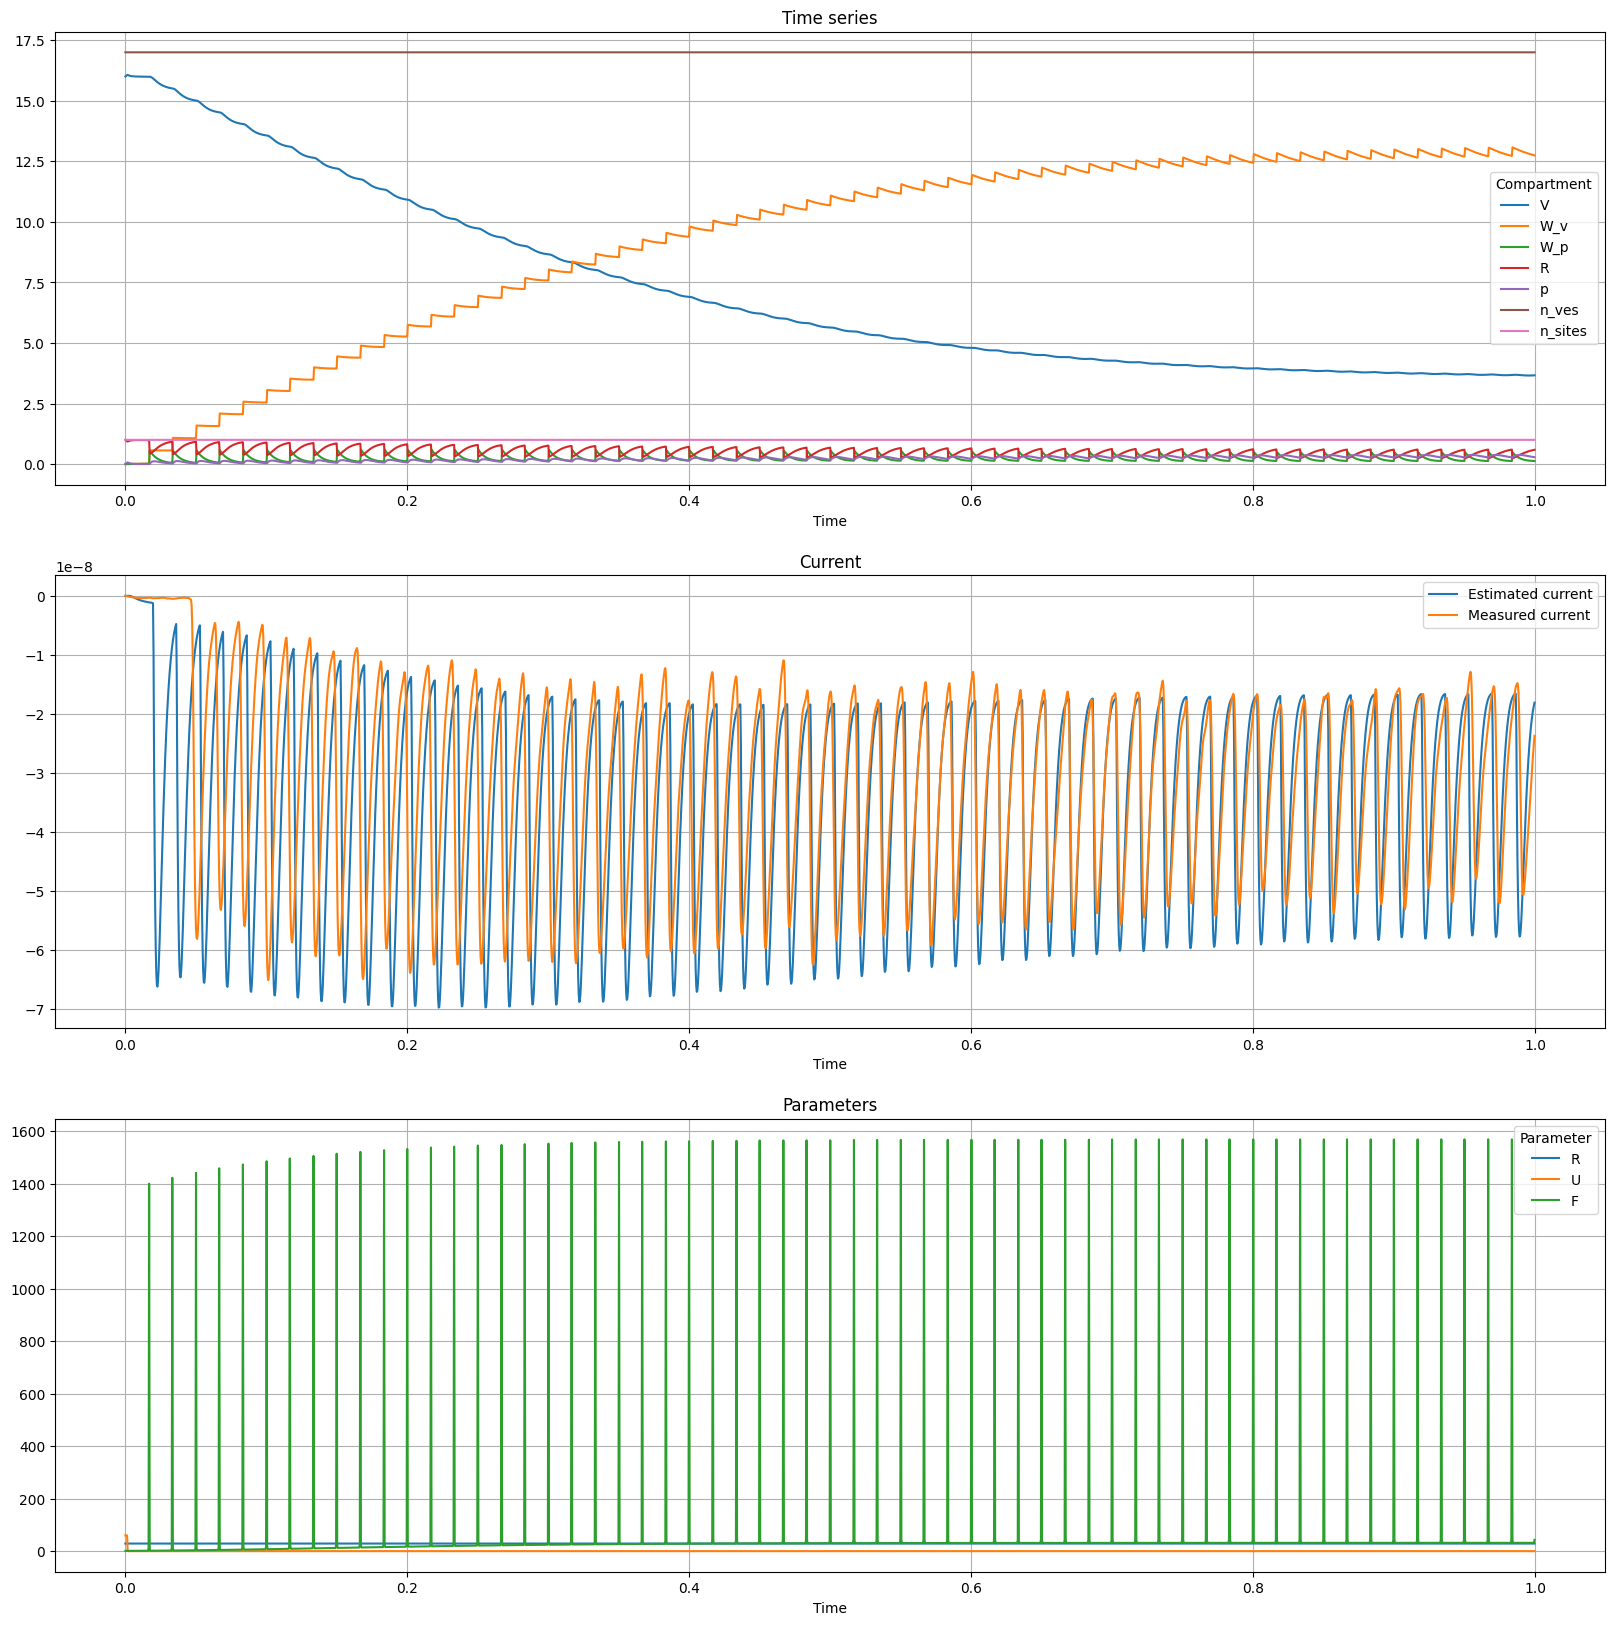

In [407]:
# Generate ODE data
X = solve_ODE(parameters=true_params, num_steps=num_steps, init_state=init_state, dt=dt, **ANIMAL_PARAMS[animal])
n_ves, n_sites = X[:, [Compartments["R"].value, Compartments["W_v"].value, Compartments["V"].value]].sum(dim=1)[:-1].reshape(-1, 1), X[:, [Compartments["R"].value, Compartments["p"].value, Compartments["W_p"].value]].sum(dim=1)[:-1].reshape(-1, 1)

# Calculate current
g = impulse_function(times[start:stop], **GENERAL_PARAMS['impulse_function'])
C = calculate_current(R=X[:, Compartments["R"].value][:-1], k_F = true_params[:, Parameters["F"].value], g=g, N=ANIMAL_PARAMS[animal]["N"], dt=dt)

# Plot the results
fig, axs = plt.subplots(nrows=3, figsize=(20, 20))
xr.DataArray(np.hstack([X[:-1], n_ves, n_sites]),
             dims=["Time", "Compartment"],
             coords={"Time": times[start:stop], "Compartment": [e.name for e in Compartments] + ['n_ves'] + ['n_sites']}
             ).plot(hue="Compartment", ax=axs[0])
xr.DataArray(C[start:stop],
             dims=["Time"],
             coords={"Time": times[start:stop]}).plot(ax=axs[1], label="Estimated current")
xr.DataArray(true_params,
             dims = ["Time", "Parameter"],
             coords= {"Time": times[start:stop], "Parameter": [e.name for e in Parameters]}).plot(hue="Parameter", ax=axs[2])

axs[0].set(title="Time series")
axs[1].set(title="Current")
axs[2].set(title="Parameters")
for ax in axs:
    ax.grid()
axs[1].plot(times[start:stop], currents[animal][start:stop], label="Measured current")
axs[1].legend()

print(f'nves: {n_ves.mean()}, nsites: {n_sites.mean()}')

In [427]:
# Initialise the neural network
NN = neural_net.NeuralNet(
    input_size = 2, # Two time series points
    output_size = 3, # Number of parameters
    num_layers=5,
    nodes_per_layer={"default": 20}, 
    activation_funcs={"default": "leakyrelu", "layer_specific": {-1: "softplus"}},
    learning_rate=0.002,
    optimizer='Adam',
    biases={"default": None}
)

# Store the training loss
loss_ts = []

In [428]:
C_train = currents[animal][start:stop] * 10**8
g_train = g[start:stop]

In [439]:
# Single training epoch
def epoch(training_X):
    
    # Make a prediction 
    predicted_params = NN(torch.hstack([training_X[:-1], training_X[1:]]))
    
    # Generate a time series
    predicted_time_series = solve_ODE(parameters=predicted_params, init_state=init_state, num_steps=training_X.shape[0]-1, dt=dt, **ANIMAL_PARAMS[animal])

    # Get the current
    predicted_current = calculate_current(R=predicted_time_series[:, Compartments["R"].value][:-1],
                                          k_F=predicted_params[:, Parameters["F"].value], dt=dt,
                                          g=g_train, **ANIMAL_PARAMS[animal])

    # Calculate gradient of loss
    loss = torch.nn.functional.mse_loss(predicted_current * 10**8, C_train[:-1])
    #loss = torch.nn.functional.mse_loss(predicted_time_series, training_X)

    # Penalise variance of k_R to make it constant
    loss = loss + torch.abs((predicted_params[:, Parameters["R"].value]).diff()).mean()

    # Get gradients
    loss.backward()
    
    # Can clip the gradients to prevent large oscillations (usually not necessary though)
    #torch.nn.utils.clip_grad_norm_(NN.parameters(), max_norm=1)
    
    # Step
    NN.optimizer.step()
    NN.optimizer.zero_grad()
    
    return loss.detach()

In [470]:
for i in (pbar := tqdm.trange(1000)):
    _l = epoch(C_train.reshape(-1, 1))
    loss_ts.append(_l)
    pbar.set_description(f"Current loss: {_l}")

Current loss: 1.8654522895812988:  90%|████████▉ | 895/1000 [08:05<00:56,  1.84it/s]


KeyboardInterrupt: 

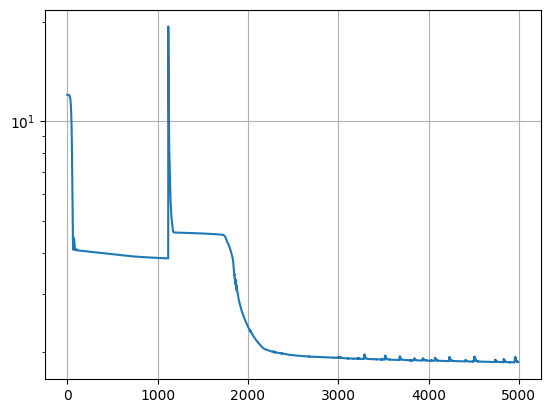

In [474]:
plt.plot(loss_ts)
plt.yscale('log')
plt.grid()

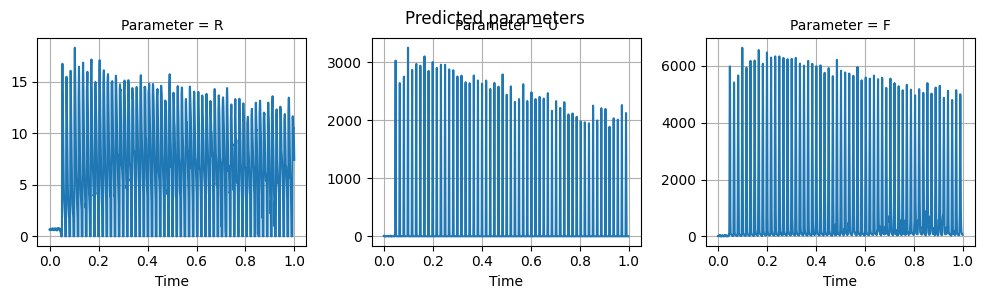

In [475]:
# Plot the results
predicted_params = NN(torch.hstack([C_train.reshape(-1, 1)[:-1], C_train.reshape(-1, 1)[1:]])).detach()
fg = xr.DataArray(predicted_params,
             dims=["Time", "Parameter"],
             coords={"Time": times[:stop-1], "Parameter": [e.name for e in Parameters]}).plot(col="Parameter", sharey=False)
fg.fig.suptitle("Predicted parameters")
for ax in fg.axs.flatten():
    ax.grid()

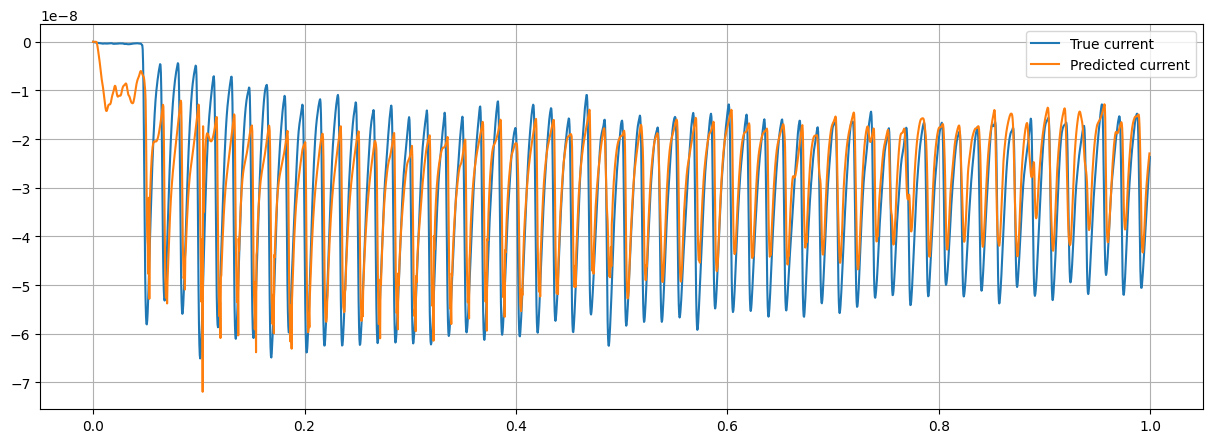

In [476]:
# Plot the resulting current
predicted_time_series = solve_ODE(parameters=predicted_params.data, init_state=init_state, dt=dt, num_steps=predicted_params.shape[0], **ANIMAL_PARAMS[animal])
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(times[:stop], C_train*10**-8, label='True current')
ax.plot(times[:stop-1], calculate_current(R=predicted_time_series[:, Compartments["R"].value][:-1], k_F = predicted_params[:, Parameters["F"].value], g=g_train, dt=dt, **ANIMAL_PARAMS[animal]), label='Predicted current')
ax.legend()
ax.grid()